# __Application of a PCM to the argo reference data base__

The aim of this notebook is to apply a Profile Clasification Model (PCM) to the reference profiles chosen by OWC software for correcting an specific profile. The profile WMO is chosen below and the reference profiles comes from the argo reference database. All paths are read from the ow_config.txt file. The notebook produce a .txt including class labels than can be read for the modified version of OWC included in thsi repository. 
The PCM allows to classify oceanographic profiles depending on its shape (look at BlueCloud notebooks). By using the output of this notebooks in the OWC software, only reference profiles in the same class than de float profiles are used to evaluated it, so profiles in the same dynamic region.
Authors
Logos

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter

from classif_functions import *
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import configparser

### __User inputs__

__1. Configuration file__

Paths are read from the OWC configuration file. You should give the path to this file.

In [2]:
config_filename = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/ow_config.txt'

path to WMO_boxes_latlon.txt

In [3]:
WMOboxes_latlon='WMO_boxes_latlon.txt'

__2. Interpolation depth__

The model can not cope with NaNs should data should be interpolated to the same levels and profiles that are too short will be deleted. Please, choose the max_depth below. We recomend a value around 1000 m, to take into account an important part of the water column in the classification.

In [4]:
# depth for interpolation
max_depth = 900

__3. Season__

Maybe usefull for decorrelation of the training dataset

In [5]:
# chose season ('DJF', 'MAM', 'JJA', 'SON' or 'all') for training dataset
season = ['all']

__4. Float WMO__

Float you want to correct

In [6]:
# Galicia
#float_mat_path = config['float_source_directory'] + '/test4/6900230.mat'
#float_WMO = 6900230
# agulhas current
#float_mat_path = config['float_source_directory'] + '/test3/3901915.mat'
float_WMO = 3901915
# southern ocean
#float_mat_path = config['float_source_directory'] + '/test2/3901928.mat'
#float_WMO = 3901928
# north atlantic 
#float_mat_path = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/data/float_source/test1/4900136.mat'
#float_WMO = 4900136

__5. Model parameters__

Please choose the number of classes. You can have un idea of the best number of classes in your dataset by using the BIC_calculation notebook

In [7]:
K=6 # number of classes

## 1. Load argo reference database

Important paths are readed form the config file and data is loaded from the argo reference database

Read OWC configuration file

In [8]:
with open(config_filename) as f:
    file_content = '[configuration]\n' + f.read()

config_parser = configparser.RawConfigParser(comment_prefixes='%')
config_parser.read_string(file_content)
config = config_parser['configuration']

In [9]:
#wmo_boxes= config['config_directory'] + config['config_wmo_boxes']
wmo_boxes='wmo_boxes_ctd.mat'
#ref_path = '/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology/'
ref_path = config['historical_directory']
float_mat_path = config['float_source_directory'] + '/test3/' + str(float_WMO)+ '.mat'

__Load argo reference database__

Talk about ellipses and PV option

In [10]:
ds = get_refdata(float_mat_path = float_mat_path, 
                 WMOboxes_latlon = WMOboxes_latlon, 
                 wmo_boxes = wmo_boxes, 
                 ref_path = ref_path,
                 config = config,
                 map_pv_use = 0)

/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3100.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3200.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3300.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3400.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3500.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3101.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3201.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3301.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3401.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3501.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//historical_ctd/ctd_3302.mat
/home5/pharos/argo/DMARGO/OW/VER

In [11]:
print(ds)

<xarray.Dataset>
Dimensions:     (n_pres: 12081, n_profiles: 2943)
Coordinates:
    long        (n_profiles) float64 1.17 8.952 6.762 4.0 ... 356.8 359.3 354.6
    lat         (n_profiles) float64 -18.0 -18.76 -18.65 ... -46.31 -44.9 -40.7
    dates       (n_profiles) datetime64[ns] 1983-10-19T06:04:12 ... 1993-01-1...
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 2937 2938 2939 2940 2941 2942
  * n_pres      (n_pres) int64 0 1 2 3 4 5 ... 12076 12077 12078 12079 12080
Data variables:
    pres        (n_pres, n_profiles) float64 1.0 2.0 2.0 2.0 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 18.86 25.27 24.14 ... nan nan nan
    sal         (n_pres, n_profiles) float64 35.95 35.87 36.14 ... nan nan nan
    source      (n_profiles) <U41 '11115926' '11124818' ... '2634943'
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed M...
    __version__:  1.0
    __globals__:  1.0


## 2. Create training dataset

Use a regular sampling

In [ ]:
ds_t = ds

In [ ]:
%%time
corr_dist = 50 # in km
ds_t = get_regulargrid_dataset(ds, corr_dist, season=season)

In [ ]:
print(ds_t)

plot dataset

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
sc = ax.pcolor(np.tile(np.arange(len(ds_t['n_profiles'])), (len(ds_t['n_pres']),1)), ds_t['pres'], ds_t['temp'], cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)', fontsize=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('n_profiles', fontsize=10);

__Interpolate to standard levels__

In [ ]:
std_lev = np.arange(0,max_depth)
ds_t = interpolate_standard_levels(ds_t, std_lev)

In [ ]:
# some format
#pres should be negative for the PCM
ds_t['PRES_INTERPOLATED'] = -np.abs(ds_t['PRES_INTERPOLATED'].values)
#axis attributtes for plotter class
ds_t.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds_t.lat.attrs['axis'] = 'Y'
ds_t.long.attrs['axis'] = 'X'
ds_t.dates.attrs['axis'] = 'T'

In [ ]:
print(ds_t)

In [ ]:
ds_t['temp'].plot(x='n_profiles');

Spatial distribution of training dataset

In [ ]:
#ds_t = ds
proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds_t['long'], ds_t['lat'], s=3, transform=proj, label='Argo reference data')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

## 3. Create prediction dataset

Add float data to initial dataset

In [12]:
ds_p = add_floatdata(float_WMO, float_mat_path, ds)

In [13]:
print(ds_p)

<xarray.Dataset>
Dimensions:     (n_pres: 12081, n_profiles: 3148)
Coordinates:
    long        (n_profiles) float64 1.17 8.952 6.762 4.0 ... 350.6 350.5 350.3
    lat         (n_profiles) float64 -18.0 -18.76 -18.65 ... -27.91 -27.8 -27.73
    dates       (n_profiles) datetime64[ns] 1983-10-19T06:04:12 ... 2021-01-01
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 3142 3143 3144 3145 3146 3147
  * n_pres      (n_pres) int64 0 1 2 3 4 5 ... 12076 12077 12078 12079 12080
Data variables:
    pres        (n_pres, n_profiles) float64 1.0 2.0 2.0 2.0 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 18.86 25.27 24.14 ... nan nan nan
    sal         (n_pres, n_profiles) float64 35.95 35.87 36.14 ... nan nan nan
    source      (n_profiles) <U41 '11115926' '11124818' ... 'selected_float_206'
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed M...
    __version__:  1.0
    __globals__:  1.0


plot dataset

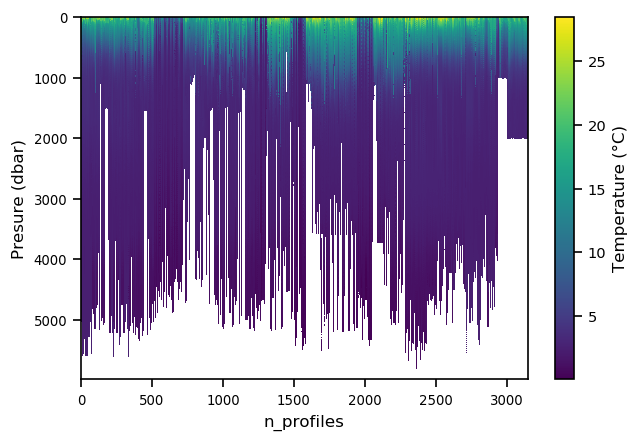

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
sc = ax.pcolor(np.tile(ds_p['n_profiles'], (len(ds_p['n_pres']),1)), ds_p['pres'], ds_p['temp'], cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)', fontsize=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('n_profiles', fontsize=10);

__Interpolate to standard levels__

In [15]:
std_lev = np.arange(0,max_depth)
ds_p = interpolate_standard_levels(ds_p, std_lev)

/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/classif_functions.py:128: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [16]:
# some format
#pres should be negative for the PCM
ds_p['PRES_INTERPOLATED'] = -np.abs(ds_p['PRES_INTERPOLATED'].values)
#axis attributtes for plotter class
ds_p.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds_p.lat.attrs['axis'] = 'Y'
ds_p.long.attrs['axis'] = 'X'
ds_p.dates.attrs['axis'] = 'T'

In [17]:
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 900, n_profiles: 3148)
Coordinates:
    long               (n_profiles) float64 1.17 8.952 6.762 ... 350.5 350.3
    lat                (n_profiles) float64 -18.0 -18.76 -18.65 ... -27.8 -27.73
    dates              (n_profiles) datetime64[ns] 1983-10-19T06:04:12 ... 20...
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 3143 3144 3145 3146 3147
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 1.0 1.0 ... 899.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.95 ... 34.39
    source             (n_profiles) object '11115926' ... 'selected_float_206'
    temp               (n_profiles, PRES_INTERPOLATED) float64 18.86 ... 4.329
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed M...
    __version__:  1.0
    __globals__:  1.0


__Plot float trajectory and ref profiles__

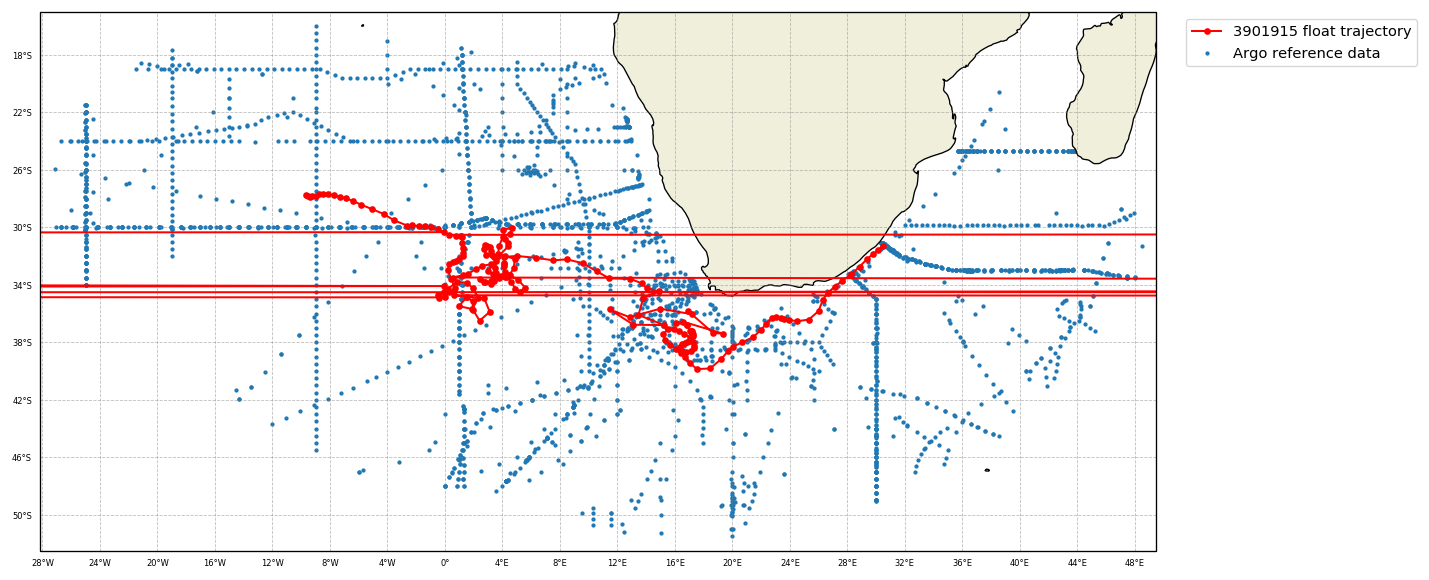

In [18]:
selected_float_index = [i for i, isource in enumerate(ds_p['source'].values) if 'selected_float' in isource]

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds_p['long'], ds_p['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax.plot(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
                 'ro-', transform=proj, markersize = 3, label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
lon_180 = np.mod((ds_p['long']+180),360)-180
ax.set_xlim([lon_180.min()-1, lon_180.max()+1])
ax.set_ylim([ds_p['lat'].min()-1, ds_p['lat'].max()+1])


plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

## 4. Apply PCM

Create model

In [ ]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
z = ds_t[z_dim]
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

m = pcm(K=K, features=pcm_features)
m

Fit model

In [ ]:
var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

m.fit(ds_t, features=features_in_ds, dim=z_dim)
m

__or load model !!!!!__

In [19]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']
var_name_ds = ['temp', 'sal']
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

In [20]:
m = pyxpcm.load_netcdf('models/model_CTD_3901915_K6_FINAL.nc')

Predict labels

In [21]:
#ds_p = ds_t
m.predict(ds_p, features=features_in_ds, inplace = True)
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 900, n_profiles: 3148)
Coordinates:
    long               (n_profiles) float64 1.17 8.952 6.762 ... 350.5 350.3
    lat                (n_profiles) float64 -18.0 -18.76 -18.65 ... -27.8 -27.73
    dates              (n_profiles) datetime64[ns] 1983-10-19T06:04:12 ... 20...
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 3143 3144 3145 3146 3147
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 1.0 1.0 ... 899.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.95 ... 34.39
    source             (n_profiles) object '11115926' ... 'selected_float_206'
    temp               (n_profiles, PRES_INTERPOLATED) float64 18.86 ... 4.329
    PCM_LABELS         (n_profiles) int64 3 3 3 3 3 3 3 3 3 ... 4 4 4 4 4 4 4 4
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed M..

In [22]:
#ds_p = order_class_names(ds_p, K=K)

In [23]:
m.predict_proba(ds_p, features=features_in_ds, dim=z_dim, inplace=True);

In [24]:
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[0], outname=var_name_ds[0] + '_Q', keep_attrs=True, inplace=True)
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[1], outname=var_name_ds[1] + '_Q', keep_attrs=True, inplace=True)

calculate robustness

In [25]:
ds_p.pyxpcm.robustness(m, inplace=True)
ds_p.pyxpcm.robustness_digit(m, inplace=True)

<xarray.Dataset>
Dimensions:             (PRES_INTERPOLATED: 900, n_profiles: 3148, pcm_class: 6, quantile: 3)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3 4 5
    long                (n_profiles) float64 1.17 8.952 6.762 ... 350.5 350.3
    lat                 (n_profiles) float64 -18.0 -18.76 ... -27.8 -27.73
    dates               (n_profiles) datetime64[ns] 1983-10-19T06:04:12 ... 2...
  * n_profiles          (n_profiles) int64 0 1 2 3 4 ... 3144 3145 3146 3147
  * PRES_INTERPOLATED   (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    pres                (n_profiles, PRES_INTERPOLATED) float64 1.0 ... 899.0
    sal                 (n_profiles, PRES_INTERPOLATED) float64 35.95 ... 34.39
    source              (n_profiles) object '11115926' ... 'selected_float_206'
    temp                (n_profiles, PRES_INTERPOLATED) float64 18.86 ... 4.329
    PCM_LABELS          (n_profiles) int64 3 3 3 3 3 3 3 3 3 ... 4 4 4 4 4 4 4 4
    PCM_POST            (pcm_class, n_profiles) float64 0.0 0.0 ... 8.419e-36
    temp_Q              (pcm_class, quantile, PRES_INTERPOLATED) float64 18.3...
    sal_Q               (pcm_class, quantile, PRES_INTERPOLATED) float64 35.4...
    PCM_ROBUSTNESS      (n_profiles) float64 1.0 1.0 1.0 ... 0.9999 0.9803
    PCM_ROBUSTNESS_CAT  (n_profiles) int64 5 4 4 5 4 5 5 5 5 ... 4 4 4 4 2 4 4 3
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed M...
    __version__:  1.0
    __globals__:  1.0

In [26]:
print(ds_p)

<xarray.Dataset>
Dimensions:             (PRES_INTERPOLATED: 900, n_profiles: 3148, pcm_class: 6, quantile: 3)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3 4 5
    long                (n_profiles) float64 1.17 8.952 6.762 ... 350.5 350.3
    lat                 (n_profiles) float64 -18.0 -18.76 ... -27.8 -27.73
    dates               (n_profiles) datetime64[ns] 1983-10-19T06:04:12 ... 2...
  * n_profiles          (n_profiles) int64 0 1 2 3 4 ... 3144 3145 3146 3147
  * PRES_INTERPOLATED   (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    pres                (n_profiles, PRES_INTERPOLATED) float64 1.0 ... 899.0
    sal                 (n_profiles, PRES_INTERPOLATED) float64 35.95 ... 34.39
    source              (n_profiles) object '11115926' ... 'selected_float_206'
    temp                (n_profiles, PRES_INTERPOLATED) float64 18.86 ... 4.329
    PCM_LABELS          (n_profiles) int

## 6. Plots

In [27]:
P = Plotter(ds_p, m, coords_dict= {'latitude': 'lat', 'longitude': 'long', 'time': 'dates'}, cmap_name='tab10')
P.data_type = 'profiles'

vertical structure

In [ ]:
P.vertical_structure(q_variable = var_name_ds[0] + '_Q', sharey=True, xlabel='Temperature (°C)', xlim=[0, 28])

In [ ]:
P.vertical_structure(q_variable = var_name_ds[1] + '_Q', sharey=True, xlabel='Salinity (PSU)', xlim=[33.5,37])

In [ ]:
P.vertical_structure_comp(q_variable = var_name_ds[0] + '_Q', plot_q= 'all', xlabel='Temperature (°C)')

In [ ]:
P.vertical_structure_comp(q_variable = var_name_ds[1] + '_Q', plot_q= 'all', xlabel='Salinity (PSU)')

spatial distribution

selected_float_30
2972
selected_float_40
2982
selected_float_50
2992
selected_float_60
3002
selected_float_70
3012
selected_float_72
3014
selected_float_80
3022


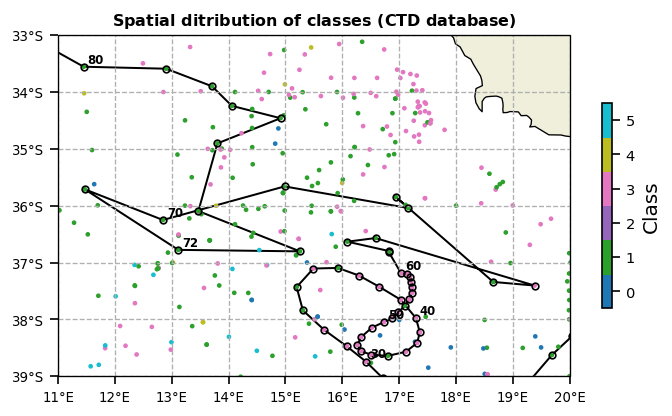

In [28]:
P.spatial_distribution(extent=[11,20,-39,-33], lonlat_grid =[1,1])
#P.spatial_distribution(lonlat_grid =[8,8])

In [ ]:
float_labels

In [ ]:
float_source[float_labels==2]

In [ ]:
float_long = ds_p['long'].isel(n_profiles = selected_float_index)
float_lat = ds_p['lat'].isel(n_profiles = selected_float_index)
float_lat[float_source=='selected_float_79']

__plot probability__

In [ ]:
float_labels = ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index)
float_post = ds_p['PCM_POST'].isel(n_profiles = selected_float_index, pcm_class = float_labels.astype(np.int16))
float_source = ds_p['source'].isel(n_profiles = selected_float_index)
float_cycles = [int(float_source.values[i].lstrip('selected_float_')) for i in range(len(float_source))]
cycles_labels = np.arange(10,float_cycles[-1],10)

kmap = m.plot.cmap(name='Accent')

fig, ax = plt.subplots(figsize=(30, 10))

rects1 = ax.plot(float_cycles, float_post, '-', zorder=-1)
rects2 = ax.scatter(float_cycles, float_post, s=40, c=float_labels, cmap=kmap, zorder=1, vmin=0, vmax=K)

ax.set_ylabel('Posteriors', fontsize=20)

ax.set_xlabel('float ' + str(float_WMO) + ' profile number', fontsize=20)
ax.set_xticks(cycles_labels)
ax.set_xlim([0.5,float_cycles[-1]+0.5])

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_title('Probability of a profile to be in its class', fontsize=20)

cbar = plt.colorbar(rects2, shrink=0.5, pad=0.01)
cbar.set_ticks(np.arange(0.5, K+0.5))
cbar.set_ticklabels(range(K))
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Class', fontsize=20)

__plot robustness__

In [ ]:
float_labels = ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index)
float_robust = ds_p['PCM_ROBUSTNESS_CAT'].isel(n_profiles = selected_float_index)
float_source = ds_p['source'].isel(n_profiles = selected_float_index)
float_cycles = [int(float_source.values[i].lstrip('selected_float_')) for i in range(len(float_source))]
cycles_labels = np.arange(10,float_cycles[-1],10)

kmap = m.plot.cmap(name='Accent')

fig, ax = plt.subplots(figsize=(30, 10))

rects1 = ax.plot(float_cycles, float_robust, '-', zorder=-1)
rects2 = ax.scatter(float_cycles, float_robust, s=40, c=float_labels, cmap=kmap, zorder=1, vmin=0, vmax=K)

ax.set_ylabel('Robustness', fontsize=20)
ax.set_yticks(np.arange(1,5+1))
ax.set_yticklabels(ds_p['PCM_ROBUSTNESS_CAT'].attrs['legend'], fontsize=16)

ax.set_xlabel('float ' + str(float_WMO) + ' profile number', fontsize=20)
ax.set_xticks(cycles_labels)
ax.set_xlim([0.5,float_cycles[-1]+0.5])
ax.set_xticklabels(cycles_labels, fontsize=16)

ax.set_title('Robustness of each float profile', fontsize=20)

cbar = plt.colorbar(rects2, shrink=0.5, pad=0.01)
cbar.set_ticks(np.arange(0.5, K+0.5))
cbar.set_ticklabels(range(K))
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Class', fontsize=20)

__plot float trajectory with classes__

In [ ]:
ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index)
#ds_p['source'].isel(n_profiles = selected_float_index)

In [ ]:
len(ds_p['source'].isel(n_profiles = selected_float_index))

In [ ]:
selected_float_index = [i for i, isource in enumerate(ds_p['source'].values) if 'selected_float' in isource]

kmap = m.plot.cmap(name='Accent')

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

#p1 = ax.scatter(ds_p['long'], ds_p['lat'], s=3, c=ds_p['PCM_LABELS'], cmap=kmap, transform=proj, label='Argo reference data', alpha=0)

p3 = ax.plot(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
                 'k-', transform=proj)

p2 = ax.scatter(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
                s=20, c=ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index), cmap=kmap, transform=proj)
#p1 = ax.scatter(ds_p['long'], ds_p['lat'], s=3, c=ds_p['PCM_LABELS'], cmap=kmap, transform=proj, label='Argo reference data')

#p3 = ax.plot(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
#                 'b-', transform=proj, markersize = 3, markerfacecolor="None", label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
lon_180 = np.mod((ds_p['long'].isel(n_profiles = selected_float_index)+180),360)-180
ax.set_xlim([lon_180.min()-1, lon_180.max()+1])
ax.set_ylim([ds_p['lat'].isel(n_profiles = selected_float_index).min()-1, ds_p['lat'].isel(n_profiles = selected_float_index).max()+1])

cbar = plt.colorbar(p1, shrink=0.3)
cbar.set_ticks(np.arange(0.5, K+0.5))
#cbar.set_ticklabels(range(K))

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

In [ ]:
range(K)

Classes pie chart

In [ ]:
P.pie_classes()

Temporal representation

Bar plot by month

In [ ]:
P.temporal_distribution(time_bins = 'month')

Bar plot by season

In [ ]:
P.temporal_distribution(time_bins = 'season')

## 7. Output

Create a .txt file with classes

In [ ]:
#create array with source, lat, long and PCM_labels
# change long values to 0-360 as used in OW
#long_360 = np.mod(ds_p['long'].values, 360)

matrix_txt = np.stack(('"'+ ds_p['source'].values + '"', ds_p['lat'].values, ds_p['long'].values, ds_p['PCM_LABELS'].values), axis=1)
#matrix_txt = np.stack((ds_p['source'].values, ds_p['lat'].values, long_360, ds_p['PCM_LABELS'].values), axis=1)
header = 'source lat long PCM_LABELS'
print([ds_p['long'].min(), ds_p['long'].max()])

f= open("output_files/PCM_classes_3901915_CTD_k6_FINAL.txt","w+")
np.savetxt(f, matrix_txt, fmt=['%s', '%.3f', '%.3f', '%.1f'], header=header)
f.close() 

In [ ]:
m.to_netcdf('models/model_CTD_3901915_K6_FINAL.nc')

## 8. Plot with AVISO

Load AVISO data

In [ ]:
path_aviso = '/home1/homedir5/perso/agarciaj/EARISE/data/AVISO_gulfstream_2004.nc'
ds_aviso = xr.open_dataset(path_aviso)
ds_aviso

In [ ]:
ds_aviso['longitude'] = np.mod((ds_aviso.longitude.values+180),360)-180
ds_aviso

In [ ]:
time_step = '2004-09-03'

scatter plot using class

In [ ]:
selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

sc = ax.pcolormesh(ds_aviso['longitude'], ds_aviso['latitude'], ds_aviso['adt'].sel(time = time_step), cmap='bwr', transform=proj)
p1 = ax.scatter(ds_out['long'].isel(n_profiles = selected_float_index), ds_out['lat'].isel(n_profiles = selected_float_index), 
                 s=8, c=ds_out['PCM_LABELS'].isel(n_profiles = selected_float_index), transform=proj, cmap='Accent')
#p2 = ax.scatter(ds_out['long'], ds_out['lat'], s=3, transform=proj, label='Argo reference data')
#p3 = ax.plot(ds_out['long'].isel(n_profiles = selected_float_index), ds_out['lat'].isel(n_profiles = selected_float_index), 
#                 'ro-', transform=proj, markersize = 3, label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim([-64,-48])
legend1 = ax.legend(*p1.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)